In [1]:
from pylab import *
import h5py
from scipy.optimize import curve_fit
#from scipy.stats import binned_statistic_dd
from lib.analysis_library import vectorized_binned_statistic_dd
import filter_masks
import pickle
from scipy import stats
from sklearn.datasets import make_blobs
import pandas as pd

import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
import hdbscan



In [2]:
#load data
experiment_run_name = "sxri0414run72"
my_file = experiment_run_name+".h5"
my_hdf5_object = h5py.File("small_h5_data/"+my_file,"r")

In [3]:
#convert hdf5 to dict
my_list = []
def func(name, obj):
    my_list.append(name)

my_hdf5_object.visititems(func)
my_dict = {}
for i in my_list:
    my_dict[i] = array(my_hdf5_object[i])

In [4]:
#configuration parameters
time_tool_sign = 1
pixel_to_femtosecond = 0.0033444
delay_stage_offset = min(my_dict['delayStage'])

In [5]:
clusterer = hdbscan.HDBSCAN()

In [31]:
my_data, labels = make_blobs(n_samples=2000, n_features=10)

In [7]:
blobs.shape

(2000, 10)

In [36]:
my_data = nan_to_num(array([my_dict['GMD'],my_dict['acqiris2/amplitude'],
                 my_dict['acqiris2/uncertainty_cov'],my_dict['ebeam/photon_energy'],
                  my_dict['ebeam/L3_energy'],my_dict['gas_detector/f_11_ENRC'],
                 my_dict['timeToolOpal/time_pixel'],my_dict['timeToolOpal/uncertainty_cov'],
                            my_dict['evr/code_141'],my_dict['evr/code_162'],
                            my_dict['evr/code_142']])).transpose()

In [32]:
my_data.shape

(2000, 10)

In [14]:
rand(100,3).shape

(100, 3)

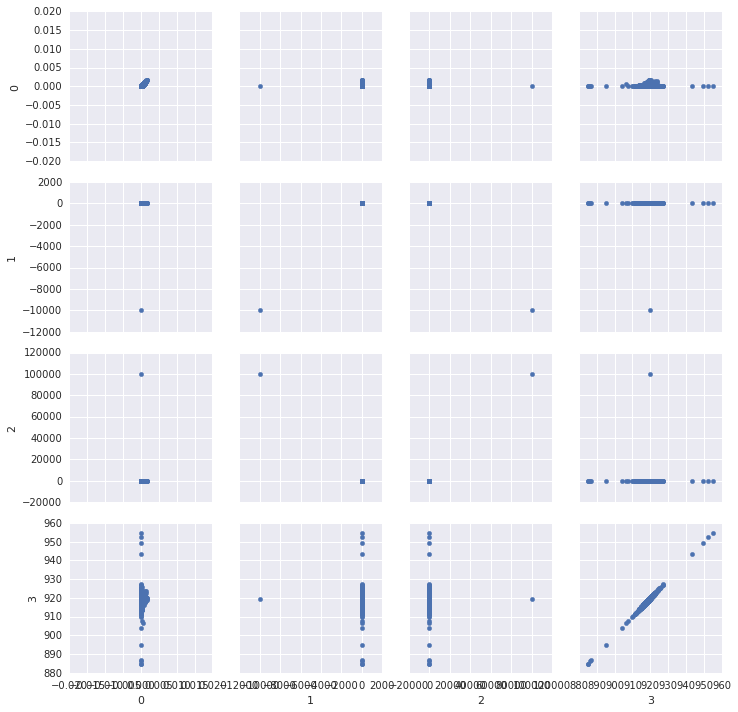

In [38]:
# The columns we will be plotting
plot_cols = ["GMD", 'acqiris2/amplitude','acqiris2/uncertainty_cov', 'ebeam/photon_energy', 'ebeam/L3_energy','gas_detector/f_11_ENRC','timeToolOpal/time_pixel','timeToolOpal/uncertainty_cov']

g = sns.PairGrid(pd.DataFrame(my_data[1:-1:100,0:4]))
g = g.map(plt.scatter)

In [65]:
# Intialize the clusterer
my_data_frame = pd.DataFrame(my_data)
clusterer = hdbscan.HDBSCAN(min_cluster_size=1500, min_samples=3, alpha=1.0)
labels = clusterer.fit_predict(pd.DataFrame(my_data))

# Append the labels to the data for later use
#data["labels"] = labels

In [72]:
my_data_frame['labels'] = labels

In [73]:
my_data_frame['labels'].value_counts()

 3    58553
 5    28042
 4    28033
-1     8678
 0     4349
 2     3865
 1     2063
Name: labels, dtype: int64

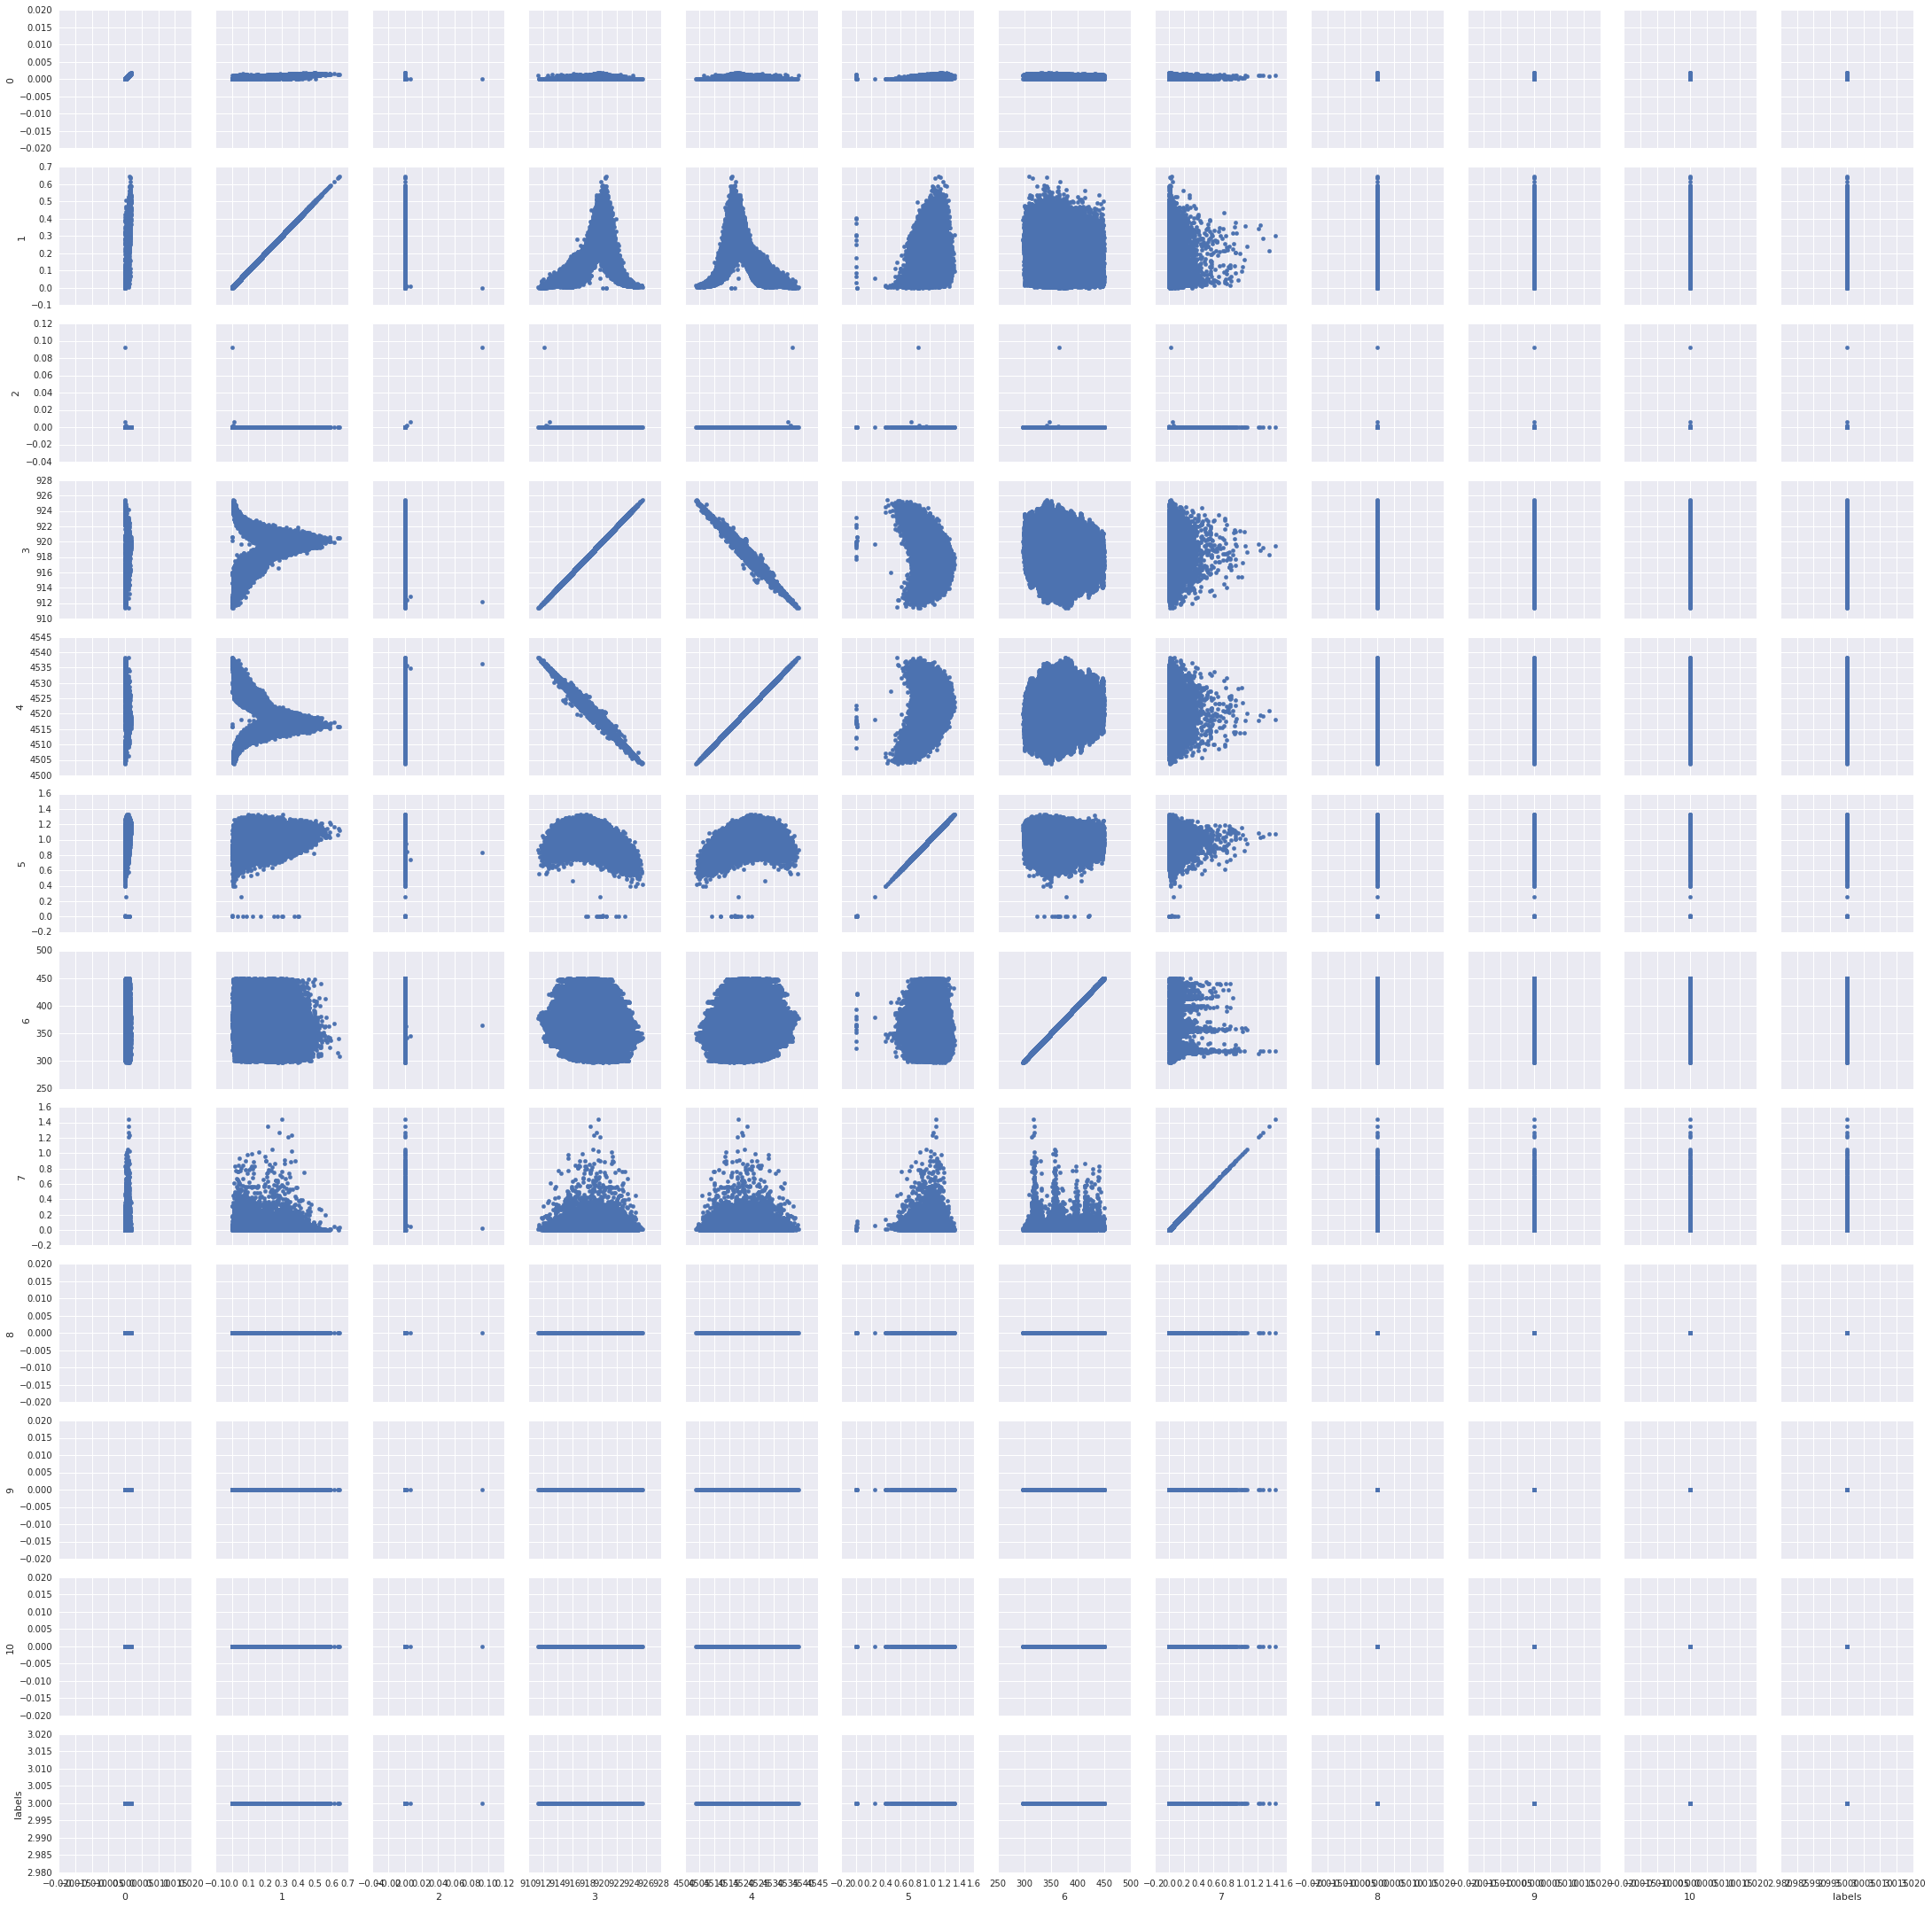

In [86]:
myMask = array(my_data_frame['labels']==3)
g = sns.PairGrid(pd.DataFrame(my_data_frame[myMask]))
g = g.map(plt.scatter)

In [85]:
type(my_data_frame[myMask])

pandas.core.frame.DataFrame

In [63]:
clusterer.fit(my_blobs)

HDBSCAN(algorithm='best', allow_single_cluster=False, alpha=1.0,
    approx_min_span_tree=True, cluster_selection_method='eom',
    core_dist_n_jobs=4, gen_min_span_tree=False, leaf_size=40,
    match_reference_implementation=False, memory=Memory(cachedir=None),
    metric='euclidean', min_cluster_size=5, min_samples=None, p=None,
    prediction_data=False)

In [60]:
clusterer.labels_

array([-1, -1, -1, -1, -1, -1, -1, -1])

In [ ]:
plot_clusters(data, hdbscan.HDBSCAN, (), {'min_cluster_size':15})

In [50]:
labels = hdbscan.HDBSCAN(min_cluster_size=115).fit_predict(my_blobs)

In [48]:
labels

array([-1, -1, -1, -1, -1, -1, -1, -1])

In [34]:
def plot_clusters(data, algorithm, args, kwds):
    start_time = time.time()
    labels = algorithm(*args, **kwds).fit_predict(data)
    end_time = time.time()
    palette = sns.color_palette('deep', np.unique(labels).max() + 1)
    colors = [palette[x] if x >= 0 else (0.0, 0.0, 0.0) for x in labels]
    plt.scatter(data.T[0], data.T[1], c=colors, **plot_kwds)
    frame = plt.gca()
    frame.axes.get_xaxis().set_visible(False)
    frame.axes.get_yaxis().set_visible(False)
    plt.title('Clusters found by {}'.format(str(algorithm.__name__)), fontsize=24)
    plt.text(-0.5, 0.7, 'Clustering took {:.2f} s'.format(end_time - start_time), fontsize=14)